#### Loading the libraries

In [1]:
import os
os.getcwd()

'd:\\MaStat 2023\\F000918A - Deep Learning\\Final Project\\DL-final_project\\transfer-learning\\damage_detection'

In [2]:
# Loading tensorflow and keras
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.activations import softmax
from tensorflow.keras.optimizers import RMSprop

#please import any required libraries
import os
from pathlib import Path
import numpy as np
import random
from shutil import copyfile
from matplotlib.image import imread
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.preprocessing. image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, MaxPool2D
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np


In [3]:
folders  = os.listdir('data/raw')
print(folders)
class_lbl = {k: v for  k, v in enumerate(folders)}
print(class_lbl)

['damage', 'no_damage']
{0: 'damage', 1: 'no_damage'}


There are two folders in the dataset, one containing the images of damage and the other without damage (no_damage).

We randomly selects 3 images from each directory in a given list, shuffles these images, and then displays them in a grid. Each image is labeled with its filename and the name of its parent directory.

(194, 259, 3)
(782, 1279, 3)
(194, 259, 3)
(194, 259, 3)
(188, 269, 3)
(192, 262, 3)


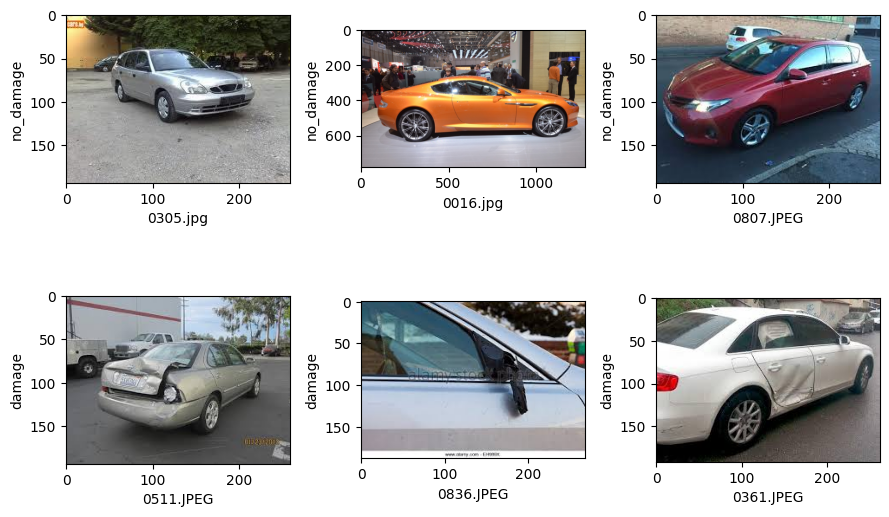

In [4]:
## Checking random images from all folders by picking randomly each time
l = []
for cls in folders:
  for f in random.sample(os.listdir(os.path.join('data/raw/', cls)), 3):
    if f not in folders:
      l.append((os.path.join('data/raw/', cls, f), f, cls))
random.shuffle(l)

n = len(l)
num_row, num_col = n // 3, 3
fig, axes = plt.subplots(num_row, num_col, figsize=(3 * num_col, 3 * num_row))

for i in range(n):
    img_path, img_name, folder_name = l[i]
    img = imread(str(img_path))
    ax = axes[i // num_col, i % num_col]
    ax.set_xlabel(f'{img_name}')
    ax.set_ylabel(f'{folder_name}')
    print(img.shape)
    ax.imshow(img)
      
plt.tight_layout()
plt.show()

##### Key Points
 1. The images are of different sizes
 2. The images are of different shapes
 3. The images are of different aspect ratios
 4. The images are of different color channels (RGB)
 5. The images are of different quality

#### Creating the folder structure for the data split

In [5]:
# Preparing data by organising into sepearate Folders
# Get all the paths
data_dir_list = os.listdir('data/raw/')
print(data_dir_list)
path, dirs, files = next(os.walk("data/"))
file_count = len(files)
# print(file_count)


# create three folders (train, validation, test) if not exists
train_dir = os.path.join('data/', 'train')
if not os.path.isdir(train_dir):
    os.mkdir(train_dir)

validation_dir = os.path.join('data/', 'validation')
if not os.path.isdir(validation_dir):
    os.mkdir(validation_dir)

test_dir = os.path.join('data/', 'test')
if not os.path.isdir(test_dir):
    os.mkdir(test_dir)


# Under train, validation and test folders create Nine folders
# ('3_4th_driver_side_front', '3_4th_driver_side_rear', '3_4th_passenger_side_front',
#       '3_4th_passenger_side_rear', 'driver_side', 'front', 'passenger_side', 'rear', 'unknown')
data_lbls = data_dir_list

for i in data_dir_list:
    if not os.path.isdir(f'{train_dir}/{i}'):
        train_files_dir = os.path.join(train_dir, i)
        os.mkdir(train_files_dir)

for i in data_dir_list:
    if not os.path.isdir(f'{validation_dir}/{i}'):
        validation_files_dir = os.path.join(validation_dir, i)
        os.mkdir(validation_files_dir)

for i in data_dir_list:
    if not os.path.isdir(f'{test_dir}/{i}'):
        test_files_dir = os.path.join(test_dir, i)
        os.mkdir(test_files_dir)

['damage', 'no_damage']


We have created the folders train, validation and test in the data folder with in each ['damage', 'no_damage'] folders for taking the data from the raw folder and using it in the data split for model building.   

#### Splitting the data into Train (75%), Validation (15%) and Test (10%) datasets. 

In [6]:
def split_data(SOURCE, TRAINING, VALIDATION, TEST, TRAIN_SIZE, VALID_SIZE):
    labels = os.listdir(SOURCE)
    for label in labels:
        files = []
        label_dir = os.path.join(SOURCE, label)
        for filename in os.listdir(label_dir):
            file = os.path.join(label_dir, filename)
            if os.path.getsize(file) > 0:
                files.append(filename)
            else:
                print(filename + " is zero length, so ignoring.")

        training_length = int(len(files) * TRAIN_SIZE)
        valid_length = int(len(files) * VALID_SIZE)
        shuffled_set = random.sample(files, len(files))
        training_set = shuffled_set[0:training_length]
        valid_set = shuffled_set[training_length:(training_length+valid_length)]
        test_set = shuffled_set[(training_length+valid_length):]

        for destination, dataset in zip([TRAINING, VALIDATION, TEST], [training_set, valid_set, test_set]):
            dataset_dir = os.path.join(destination, label)
            os.makedirs(dataset_dir, exist_ok=True)
            for filename in dataset:
                this_file = os.path.join(label_dir, filename)
                destination_file = os.path.join(dataset_dir, filename)
                copyfile(this_file, destination_file)

split_data('data/raw', 'data/train', 'data/validation', 'data/test', 0.75, 0.15)

#### Data pre-processing and resizing the data

In [7]:
#  Pre-Processing & Data Augumentation
## Data Augumentation Generator
datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
    # rescale = 1/255.0, # No need to scale as the inceptionV3 model already scales data between (-1,1)
    rotation_range=30,
    zoom_range=0.4,
    horizontal_flip=False
    )

## Pre-Processing image by resizing as there are varying sizes as we found from above 
img_width = 224
img_height = 224
batch_size = 32 # increasing batch size will cause a problem during validation 

TRAINING_DIR = 'data/train/'
VALIDATION_DIR = 'data/validation/'
TEST_DIR = 'data/test/'

train_generator = datagen.flow_from_directory(
    TRAINING_DIR,
    batch_size=batch_size,
    class_mode='categorical',
    target_size=(img_height, img_width)
)

validation_generator = datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size=batch_size,
    class_mode='categorical',
    target_size=(img_height, img_width)
)

test_generator = datagen.flow_from_directory(
    TEST_DIR,
    batch_size=batch_size,
    class_mode='categorical',
    target_size=(img_height, img_width)
)

Found 1724 images belonging to 2 classes.
Found 344 images belonging to 2 classes.
Found 232 images belonging to 2 classes.


<Figure size 640x480 with 0 Axes>

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


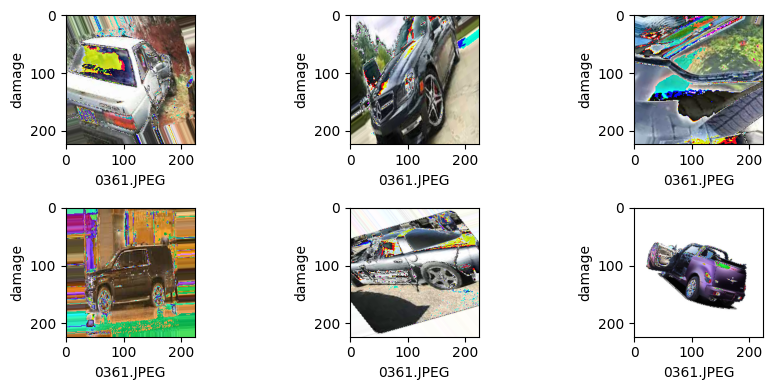

In [8]:
## Visualize First batch of train data

first_batch = next(train_generator)
# first_batch[0][0]
def visualize_batch(batch: tf.keras.preprocessing.image.DirectoryIterator):
    """Visualize a batch of train data
    
    Args:
        batch: tf.keras.preprocessing.image.DirectoryIterator
        
    Returns:
        Plot """
    
    n = 6
    num_row, num_col = 2, 3
    fig, axes = plt.subplots(num_row, num_col, figsize=(3 * num_col, 2 * num_row))
    
    for i in range(n):
        img = np.array(batch[0][i] * 255, dtype='uint8')
        ax = axes[i // num_col, i % num_col]
        ax.set_xlabel(f'{img_name}')
        ax.set_ylabel(f'{folder_name}')
        print(img.shape)
        ax.imshow(img)
        
    plt.tight_layout()
    plt.show()
     
plt.tight_layout()
plt.show()

visualize_batch(batch=first_batch)

#### Checking the size of the images coming form the ImageDataGenerator

In [9]:
from collections import defaultdict
# check the 5 image sizes coming from the train_generator, validation_generator and test_generator
train_sizes = defaultdict(int)
valid_sizes = defaultdict(int)
test_sizes = defaultdict(int)
for i in range(5):
    x, y = next(train_generator)
    for i in range(5):
        size = x[i].shape[:2]
        train_sizes[size] += 1
    x, y = next(validation_generator)
    for i in range(5):
        size = x[i].shape[:2]
        valid_sizes[size] += 1
    x, y = next(test_generator)
    for i in range(5):
        size = x[i].shape[:2]
        test_sizes[size] += 1

print('Train sizes:', train_sizes)
print('Validation sizes:', valid_sizes)
print('Test sizes:', test_sizes)

Train sizes: defaultdict(<class 'int'>, {(224, 224): 25})
Validation sizes: defaultdict(<class 'int'>, {(224, 224): 25})
Test sizes: defaultdict(<class 'int'>, {(224, 224): 25})


#### Training

In [10]:
# add Fully connected last layers( as many as you like to improve the performance), 
#try-out drop-out in Fully connected layers if you think it is necessary
def add_new_last_layer(base_model, n_classes, fc_layer_size):
    """Add last layer to the convnet
    
    Args:
        base_model: keras model excluding top
        nb_classes: # of classes
        
    Returns:
        new keras model with last layer
    """
    base_model_output = base_model.output
    # x = MaxPooling2D()(base_model_output)
    x = Dropout(0.4)(base_model_output)
    model_flat = Flatten()(base_model_output)
    predictions = Dense(n_classes, activation='sigmoid', name='predictions')(model_flat)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model 

model = InceptionV3(input_shape = (224, 224, 3), weights='imagenet', include_top=False)
# model.summary()
for i in model.layers:
  i.trainable=False

# Add new last layer with adjusted size (e.g., 256 neurons)
model = add_new_last_layer(model, n_classes=2, fc_layer_size= (512))

In [11]:
model.count_params()

21905186

In [12]:
# model.layers.trainable
sum([i.trainable for i in model.layers])

2

#### Compiling Model with Hyper-Parameters

In [13]:
# import ExponentialDecay
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# #Add callbacks like early stopping, cyclical or variable learning rate or anyting you feel necessary
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-5,
    decay_steps=10000,
    decay_rate=0.9)

opt = RMSprop(learning_rate=lr_schedule)
# opt = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=5e-04)
model_path = 'model/'
log_dir = 'logs/'
top_weights_path = os.path.join(os.path.abspath(model_path), 'damage_detection_weights2.h5')
callbacks_list = [
        ModelCheckpoint(top_weights_path, monitor='val_accuracy', verbose=1, save_best_only=True),
        EarlyStopping(monitor='val_accuracy', patience=5, verbose=0),
        tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=False, write_images=False)
    ]
##add Code Here
##add model compile code here
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=["accuracy"])

In [14]:
train_generator.class_indices

{'damage': 0, 'no_damage': 1}

In [16]:
## Next train all the layers
train_samples = 920 * 2  # 400*9 classes
history_tl = model.fit_generator(train_generator,
                        epochs= int(150 / 5),
                        validation_data=validation_generator,
                        callbacks=callbacks_list,
                        verbose=1)


C:\Users\Samuel\AppData\Local\Temp\ipykernel_29840\1810470537.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_tl = model.fit_generator(train_generator,


Epoch 1/30
54/54 [==============================] - ETA: 0s - loss: 0.5366 - accuracy: 0.7668
Epoch 1: val_accuracy improved from 0.78488 to 0.82849, saving model to d:\MaStat 2023\F000918A - Deep Learning\Final Project\DL-final_project\transfer-learning\damage_detection\model\damage_detection_weights2.h5
54/54 [==============================] - 56s 1s/step - loss: 0.5366 - accuracy: 0.7668 - val_loss: 0.4621 - val_accuracy: 0.8285
Epoch 2/30
54/54 [==============================] - ETA: 0s - loss: 0.4657 - accuracy: 0.8016
Epoch 2: val_accuracy did not improve from 0.82849
54/54 [==============================] - 57s 1s/step - loss: 0.4657 - accuracy: 0.8016 - val_loss: 0.4455 - val_accuracy: 0.8256
Epoch 3/30
54/54 [==============================] - ETA: 0s - loss: 0.4467 - accuracy: 0.8225
Epoch 3: val_accuracy improved from 0.82849 to 0.83140, saving model to d:\MaStat 2023\F000918A - Deep Learning\Final Project\DL-final_project\transfer-learning\damage_detection\model\damage_detec

In [17]:
# Save the model
history_dict = model.history.history
history_dict = {'history': history_dict}


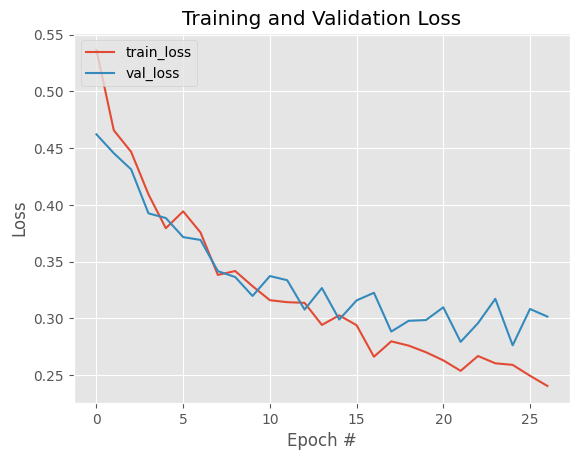

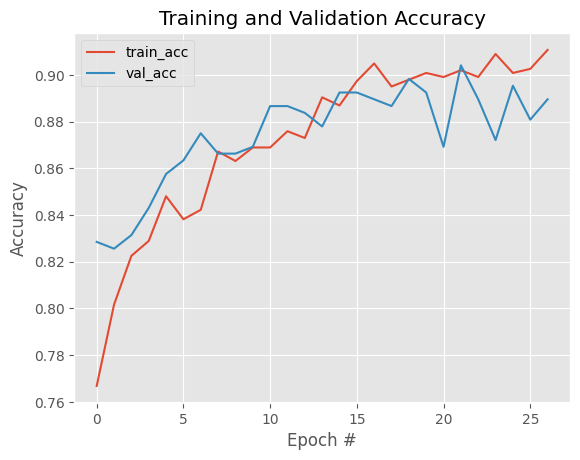

In [18]:
# plot the training and validation loss
N = len(history_dict['history']["loss"])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_dict['history']["loss"], label="train_loss")
plt.plot(np.arange(0, N), history_dict['history']["val_loss"], label="val_loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper left")
plt.show()

# plot the training and validation accuracy
plt.figure()
plt.plot(np.arange(0, N), history_dict['history']["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history_dict['history']["val_accuracy"], label="val_acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")
plt.show()

#### Test Data

In [19]:
import numpy as np
# import confusion_matrix
from sklearn.metrics import confusion_matrix
n_batches = len(test_generator)
cm=confusion_matrix(np.concatenate([np.argmax(test_generator[i][1], axis=1) for i in range(n_batches)]), np.argmax(model.predict_generator(test_generator, steps=n_batches), axis=1))

cm

C:\Users\Samuel\AppData\Local\Temp\ipykernel_29840\868709836.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  cm=confusion_matrix(np.concatenate([np.argmax(test_generator[i][1], axis=1) for i in range(n_batches)]), np.argmax(model.predict_generator(test_generator, steps=n_batches), axis=1))


array([[101,  15],
       [ 14, 102]], dtype=int64)

#### Classification Report of Test Data

In [20]:
rep = classification_report( np.concatenate([np.argmax(test_generator[i][1], axis=1) for i in range(n_batches)]), np.argmax(model.predict_generator(test_generator, steps=n_batches), axis=1))
print(rep)

C:\Users\Samuel\AppData\Local\Temp\ipykernel_29840\1777882828.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  rep = classification_report( np.concatenate([np.argmax(test_generator[i][1], axis=1) for i in range(n_batches)]), np.argmax(model.predict_generator(test_generator, steps=n_batches), axis=1))


              precision    recall  f1-score   support

           0       0.89      0.91      0.90       116
           1       0.90      0.89      0.90       116

    accuracy                           0.90       232
   macro avg       0.90      0.90      0.90       232
weighted avg       0.90      0.90      0.90       232



In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting normalize=True.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[101  15]
 [ 14 102]]


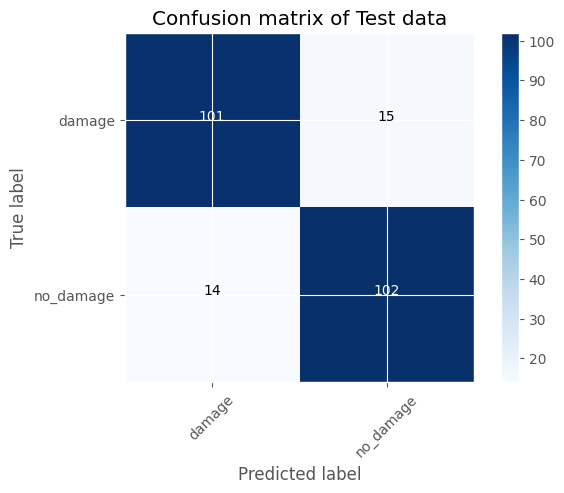

In [22]:
import itertools
plot_confusion_matrix(cm, list(test_generator.class_indices.keys()), normalize=False, title='Confusion matrix of Test data',)